# Final Project

This notebook presents a full data pipeline involving social media, news, and stock market data. The workflow includes data loading, cleaning, sentiment analysis, and storing processed data into a PostgreSQL database for further analytics.

---
## 1. Import Libraries

We begin by importing the necessary libraries for data manipulation, sentiment analysis, and database interaction.

## 2. Load Datasets

In this section, we load pre-classified datasets containing tweets, news articles, Reddit posts, and stock market data. These datasets will be cleaned and processed for sentiment analysis and database storage.


In [25]:
import pandas as pd

tweets_df1 = pd.read_csv('classified_tweets.csv')
print("Original columns and dtypes:")
print(tweets_df1.dtypes)
tweets_df1.head()

date_col = None
for col in ['date', 'Date', 'created', 'datetime', 'timestamp']:
    if col in tweets_df1.columns:
        date_col = col
        break

if date_col is None:
    raise ValueError("No recognizable date column found in classified_tweets.csv.")

tweets_df1[date_col] = pd.to_datetime(tweets_df1[date_col], utc=True, errors='coerce')
tweets_df1[date_col] = tweets_df1[date_col].dt.tz_convert('US/Eastern').dt.tz_localize(None)

tweets_df1 = tweets_df1.set_index(date_col)
tweets_df1.index.name = 'date'

print("\nAfter conversion, index dtype:", tweets_df1.index.dtype)
tweets_df1.head()


Original columns and dtypes:
Date                object
Tweet               object
user                object
Is_controversial     int64
dtype: object

After conversion, index dtype: datetime64[ns]


,Tweet,user,Is_controversial
date,,,
2025-04-13 12:00:00,What branch does he serve in?,realdonaldtrump,0
2025-04-14 10:00:00,It would be nice if American taxpayers weren't...,realdonaldtrump,1
2025-04-14 15:00:00,Friends 🇺🇸🤝🏼🇸🇻,realdonaldtrump,0
2025-04-13 01:00:00,🇺🇸 Best Friends 🇺🇸,realdonaldtrump,0
2025-04-12 16:00:00,HOLY SH*T 🚨 Italys Prime Minister Giorgia Melo...,realdonaldtrump,1


In [26]:
tweets_df2 = pd.read_csv('tweets_classified.csv')
print(tweets_df2.dtypes)
tweets_df2.head()

Id                   int64
Date                object
Text                object
Is_controversial     int64
dtype: object


,Id,Date,Text,Is_controversial
0,1666561128795713536,2023-06-07 21:41:50+00:00,"RT @SpaceX: @Space_Station And on June 6, the ...",0
1,1666498907986092046,2023-06-07 17:34:36+00:00,💕 https://t.co/uon2Tplowe,0
2,1666498723629654035,2023-06-07 17:33:52+00:00,Extremely concerning https://t.co/PLz5jrocvv,1
3,1666378734834786304,2023-06-07 09:37:04+00:00,RT @Starlink: Starlink connecting schools in P...,0
4,1666331961281900545,2023-06-07 06:31:13+00:00,This platform will provide email addresses of ...,0


In [27]:
tweets_df2['user'] = 'elonmusk'

tweets_df2['Date'] = pd.to_datetime(tweets_df2['Date'], utc=True, errors='coerce')
tweets_df2['Date'] = tweets_df2['Date'].dt.tz_convert('US/Eastern').dt.tz_localize(None)
tweets_df2 = tweets_df2.set_index('Date')
tweets_df2.index.name = 'date'

tweets_df2 = tweets_df2.rename(columns={'Text': 'Tweet'})

tweets_df2 = tweets_df2[['Tweet', 'user', 'Is_controversial']]

combined_tweets = pd.concat([tweets_df1, tweets_df2]).sort_index()

print("Combined DataFrame:")
print(combined_tweets.tail())
print("\nUnique users:", combined_tweets['user'].unique())

Combined DataFrame:
                                                                 Tweet  \
date                                                                     
2025-04-14 14:00:00  🚨 BREAKING: U.S. Attorney General Pam Bondi an...   
2025-04-14 14:00:00  🚨🚨🚨DEFUND Harvard.#BREAKING#BREAKING: Harvard ...   
2025-04-14 14:00:00  Our Ivy League schools have turned into terror...   
2025-04-14 15:00:00  NPR and PBS have a right to publish their bias...   
2025-04-14 15:00:00                                     Friends 🇺🇸🤝🏼🇸🇻   

                                user  Is_controversial  
date                                                    
2025-04-14 14:00:00  realdonaldtrump                 0  
2025-04-14 14:00:00  realdonaldtrump                 1  
2025-04-14 14:00:00  realdonaldtrump                 1  
2025-04-14 15:00:00  realdonaldtrump                 1  
2025-04-14 15:00:00  realdonaldtrump                 0  

Unique users: ['elonmusk' 'realdonaldtrump']


## 3. Data Cleaning & Preparation

We standardize column names, handle missing values, and ensure consistent data types (e.g., converting date columns to datetime objects) across all datasets to prepare them for analysis.


In [28]:
news_df = pd.read_csv('classified_news.csv')
print("Original columns and dtypes:")
print(news_df.dtypes)
news_df.head()

date_col = None
for col in ['datetime', 'Date', 'created', 'timestamp']:
    if col in news_df.columns:
        date_col = col
        break

if date_col is None:
    raise ValueError("No recognizable date column found in classified_news.csv.")

news_df[date_col] = pd.to_datetime(news_df[date_col], utc=True, errors='coerce')
news_df[date_col] = news_df[date_col].dt.tz_convert('US/Eastern').dt.tz_localize(None)


news_df = news_df.set_index(date_col)
news_df.index.name = 'date'

print("\nAfter conversion, index dtype:", news_df.index.dtype)
news_df.head()


Original columns and dtypes:
category            object
datetime            object
headline            object
id                   int64
image               object
related             object
source              object
summary             object
url                 object
symbol              object
Is_controversial     int64
dtype: object

After conversion, index dtype: datetime64[ns]


,category,headline,id,image,related,source,summary,url,symbol,Is_controversial
date,,,,,,,,,,
2025-04-10 16:00:00,company,Jim Cramer on Apple Inc. (AAPL): Can Tariffs D...,133873219,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,We recently published a list of Jim Cramer Say...,https://finnhub.io/api/news?id=03ae936f5c40e9c...,AAPL,0
2025-04-10 16:00:00,company,"These Stocks Moved the Most Today: Nvidia, App...",133873220,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,"Shares of Nvidia, Apple, and Tesla fall sharpl...",https://finnhub.io/api/news?id=ad0e76daeb145dc...,AAPL,0
2025-04-10 16:00:00,company,Why Apple Stock Is Sinking Today,133873221,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,Shares of Apple (NASDAQ: AAPL) are heading low...,https://finnhub.io/api/news?id=cac32eb61d6f66b...,AAPL,0
2025-04-10 15:00:00,company,Sector Update: Tech Stocks Plunge Late Afternoon,133873222,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,Tech stocks tumbled late Thursday afternoon wi...,https://finnhub.io/api/news?id=7e0c3404a3ccda0...,AAPL,0
2025-04-10 15:00:00,company,Apple's Efforts to Prepare for Tariffs,133873223,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,"Carolina Milanesi, Creative Strategies preside...",https://finnhub.io/api/news?id=a42a7e63b9fc06a...,AAPL,0


In [29]:
reddit_df = pd.read_csv('classified_reddit.csv')
print("Original columns and dtypes:")
print(reddit_df.dtypes)
reddit_df.head()

date_col = None
for col in ['created', 'datetime', 'Date', 'timestamp']:
    if col in reddit_df.columns:
        date_col = col
        break

if date_col is None:
    raise ValueError("No recognizable date column found in classified_reddit CSV.")

reddit_df[date_col] = pd.to_datetime(reddit_df[date_col], utc=True, errors='coerce')
reddit_df[date_col] = reddit_df[date_col].dt.tz_convert('US/Eastern').dt.tz_localize(None)

reddit_df = reddit_df.set_index(date_col)
reddit_df.index.name = 'date'

print("\nAfter conversion, index dtype:", reddit_df.index.dtype)
reddit_df.head()

Original columns and dtypes:
subreddit            object
created              object
title                object
selftext             object
upvote_ratio        float64
ups                   int64
downs                 int64
score                 int64
Is_controversial      int64
dtype: object

After conversion, index dtype: datetime64[ns]


,subreddit,title,selftext,upvote_ratio,ups,downs,score,Is_controversial
date,,,,,,,,
2025-03-01 05:00:00,stocks,Rate My Portfolio - r/Stocks Quarterly Thread ...,Please use this thread to discuss your portfol...,0.95,87,0,87,0
2025-04-14 05:00:00,stocks,"r/Stocks Daily Discussion Monday - Apr 14, 2025",These daily discussions run from Monday to Fri...,1.00,20,0,20,0
2025-04-14 09:00:00,stocks,"If the economy is crashing, why is no one acti...","My apologies if this is not a smart question, ...",0.89,4599,0,4599,0
2025-04-14 12:00:00,stocks,Genuine question: How has the US market not co...,I just don't get it. With tariffs and policies...,0.88,1647,0,1647,1
2025-04-14 14:00:00,stocks,Trump considers pausing his auto tariffs as th...,[https://finance.yahoo.com/news/trump-consider...,0.97,824,0,824,1


In [30]:
stock_df = pd.read_csv('YFinance_output.csv')

stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True, errors='coerce')
stock_df['Date'] = stock_df['Date'].dt.tz_convert('US/Eastern').dt.tz_localize(None)

stock_df = stock_df.set_index('Date')
stock_df.index.name = 'date'

print("Index dtype after standardization:", stock_df.index.dtype)
stock_df.head()


Index dtype after standardization: datetime64[ns]


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
date,,,,,,,,
1980-12-12 00:00:00,0.098726,0.099155,0.098726,0.098726,469033600.0,0.0,0.0,AAPL
1980-12-12 01:00:00,0.098726,0.099155,0.098726,0.098726,469033600.0,0.0,0.0,AAPL
1980-12-12 02:00:00,0.098726,0.099155,0.098726,0.098726,469033600.0,0.0,0.0,AAPL
1980-12-12 03:00:00,0.098726,0.099155,0.098726,0.098726,469033600.0,0.0,0.0,AAPL
1980-12-12 04:00:00,0.098726,0.099155,0.098726,0.098726,469033600.0,0.0,0.0,AAPL


In [31]:
tweets_df = combined_tweets.copy()

tweets_df.columns = tweets_df.columns.str.strip().str.lower().str.replace(' ', '_')
stock_df.columns = stock_df.columns.str.strip().str.lower().str.replace(' ', '_')
news_df.columns = news_df.columns.str.strip().str.lower().str.replace(' ', '_')
reddit_df.columns = reddit_df.columns.str.strip().str.lower().str.replace(' ', '_')

for df in [tweets_df, stock_df, news_df, reddit_df]:
    df.index = pd.to_datetime(df.index, errors='coerce')
    df.index.name = 'date'

print(tweets_df.head())
print(tweets_df.index.name)

print(tweets_df.columns)
print(stock_df.columns)
print(news_df.columns)
print(reddit_df.columns)

                                                                 tweet  \
date                                                                     
2021-09-01 20:32:46    FSD Beta 10 rolls out midnight Friday next week   
2021-09-03 04:47:10                      Time is the ultimate currency   
2021-09-04 00:04:40  RT @ErcXspace: Starbase 2023.\n\n#SpaceX #Star...   
2021-09-06 13:46:56  RT @netflix: On Sept 6, you’ll meet the four c...   
2021-09-09 17:58:55  Tesla Model S Plaid just set official world sp...   

                         user  is_controversial  
date                                             
2021-09-01 20:32:46  elonmusk                 0  
2021-09-03 04:47:10  elonmusk                 0  
2021-09-04 00:04:40  elonmusk                 0  
2021-09-06 13:46:56  elonmusk                 0  
2021-09-09 17:58:55  elonmusk                 0  
date
Index(['tweet', 'user', 'is_controversial'], dtype='object')
Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'st

## 4. Sentiment Analysis

Using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analyzer from the NLTK library, we compute sentiment scores for tweets, news headlines, and Reddit posts. These scores will help quantify the overall sentiment trends across different platforms.


In [32]:
!pip install nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/clara/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
sia = SentimentIntensityAnalyzer()

In [34]:
tweets_df['sentiment_score'] = tweets_df['tweet'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])

# Optional binning
tweets_df['sentiment_label'] = pd.cut(
    tweets_df['sentiment_score'],
    bins=[-1.01, -0.05, 0.05, 1.01],
    labels=['negative', 'neutral', 'positive']
)

100%|█████████████████████████████████████| 3392/3392 [00:00<00:00, 7519.54it/s]


In [35]:
reddit_df['full_text'] = reddit_df['title'].fillna('') + ' ' + reddit_df['selftext'].fillna('')

reddit_df['sentiment_score'] = reddit_df['full_text'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])

reddit_df['sentiment_label'] = pd.cut(
    reddit_df['sentiment_score'],
    bins=[-1.01, -0.05, 0.05, 1.01],
    labels=['negative', 'neutral', 'positive']
)

100%|███████████████████████████████████████| 914/914 [00:00<00:00, 1630.81it/s]


In [36]:
news_df['full_text'] = news_df['headline'].fillna('') + ' ' + news_df['summary'].fillna('')

news_df['sentiment_score'] = news_df['full_text'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])

news_df['sentiment_label'] = pd.cut(
    news_df['sentiment_score'],
    bins=[-1.01, -0.05, 0.05, 1.01],
    labels=['negative', 'neutral', 'positive']
)

100%|█████████████████████████████████████| 1907/1907 [00:00<00:00, 3039.83it/s]


## 5. Aggregate Daily Sentiment

Here, we resample the sentiment scores to a daily frequency, calculating average sentiment per day for each data source. This aggregation aligns the sentiment data with daily stock returns for further analysis.


In [37]:
agg_tweets_df = tweets_df.resample('D').agg({
    'sentiment_score': 'mean',
    'is_controversial': 'mean',
    'tweet': 'count'
}).rename(columns={
    'sentiment_score': 'avg_sentiment',
    'is_controversial': 'avg_controversial',
    'tweet': 'post_count'
})

In [38]:
import re

def extract_ticker(text):
    tickers = re.findall(r'\$[A-Z]{1,5}', text.upper())
    return tickers[0][1:] if tickers else None

reddit_df['ticker'] = reddit_df['full_text'].apply(extract_ticker)
reddit_df = reddit_df.dropna(subset=['ticker'])

In [39]:
news_df['ticker'] = news_df['related'].str.upper()
news_df = news_df.dropna(subset=['ticker'])

In [40]:
agg_reddit_df = reddit_df.groupby([reddit_df.index.date, 'ticker']).agg({
    'sentiment_score': 'mean',
    'is_controversial': 'mean',
    'title': 'count'
}).rename(columns={
    'sentiment_score': 'avg_sentiment',
    'is_controversial': 'avg_controversial',
    'title': 'post_count'
}).reset_index().rename(columns={'level_0': 'date'})

agg_news_df = news_df.groupby([news_df.index.date, 'ticker']).agg({
    'sentiment_score': 'mean',
    'is_controversial': 'mean',
    'headline': 'count'
}).rename(columns={
    'sentiment_score': 'avg_sentiment',
    'is_controversial': 'avg_controversial',
    'headline': 'post_count'
}).reset_index().rename(columns={'level_0': 'date'})

## 6. Calculate Stock Returns

We compute daily stock returns based on closing prices. This allows us to study potential relationships between public sentiment and stock market performance.


In [41]:
stock_df = stock_df.reset_index()
stock_df['ticker'] = stock_df['company'].str.upper()
stock_df = stock_df.sort_values(['ticker', 'date'])

# Next-day return
stock_df['next_day_close'] = stock_df.groupby('ticker')['close'].shift(-1)
stock_df['next_day_return'] = (stock_df['next_day_close'] - stock_df['close']) / stock_df['close']

In [42]:
agg_reddit_df['date'] = pd.to_datetime(agg_reddit_df['date'])
agg_news_df['date'] = pd.to_datetime(agg_news_df['date'])

In [43]:
merged_reddit = pd.merge(agg_reddit_df, stock_df, how='inner', on=['date', 'ticker'])
merged_news = pd.merge(agg_news_df, stock_df, how='inner', on=['date', 'ticker'])

In [44]:
tesla_stock = stock_df[stock_df['ticker'] == 'TSLA']

merged_tweets = pd.merge(
    agg_tweets_df.reset_index(), tesla_stock, how='inner', on='date'
)

## 7. Merge Sentiment and Stock Data

We combine the daily sentiment data from social media and news sources with stock return data into a unified dataframe. This consolidated dataset will be used for storage and further financial analysis.


In [45]:
# Combine posts
merged_tweets['source'] = 'twitter'
merged_reddit['source'] = 'reddit'
merged_news['source'] = 'news'

# Ensure consistent columns
posts_df = pd.concat([
    merged_tweets[['date', 'avg_sentiment', 'avg_controversial', 'post_count', 'ticker', 'source', 'next_day_return']],
    merged_reddit[['date', 'avg_sentiment', 'avg_controversial', 'post_count', 'ticker', 'source', 'next_day_return']],
    merged_news[['date', 'avg_sentiment', 'avg_controversial', 'post_count', 'ticker', 'source', 'next_day_return']]
])

## 8. Database Connection Setup

Using SQLAlchemy and psycopg2, we establish a connection to a PostgreSQL database where the processed data will be stored. This enables efficient querying and integration with other data systems.
|

In [46]:
pip install sqlalchemy psycopg pandas --upgrade

Note: you may need to restart the kernel to use updated packages.


In [47]:
import psycopg
from psycopg.rows import dict_row

conn = psycopg.connect(
    host="localhost",
    port="5432",
    dbname="sentiment_analysis",   # or your DB name
    user="postgres",
    password="123"
)
cur = conn.cursor(row_factory=dict_row)

cur.execute("DROP TABLE IF EXISTS aggregated_posts")
conn.commit()
cur.execute("""
CREATE TABLE aggregated_posts (
    id                 SERIAL   PRIMARY KEY,
    date               DATE     NOT NULL,
    ticker             VARCHAR(10),
    avg_sentiment      REAL,
    avg_controversial  REAL,
    post_count         INTEGER,
    source             VARCHAR(10),
    next_day_return    REAL
)
""")
conn.commit()

insert_sql = """
  INSERT INTO aggregated_posts
    (date, ticker, avg_sentiment, avg_controversial, post_count, source, next_day_return)
  VALUES (%s, %s, %s, %s, %s, %s, %s)
"""
print(f"Inserting {len(posts_df)} rows into aggregated_posts…")
for _, row in posts_df.iterrows():
    cur.execute(insert_sql, (
        row['date'].date() if hasattr(row['date'], 'date') else row['date'],
        row.get('ticker'),
        row.get('avg_sentiment'),
        row.get('avg_controversial'),
        int(row.get('post_count', 0)),
        row.get('source'),
        row.get('next_day_return')
    ))
conn.commit()

cur.execute("SELECT * FROM aggregated_posts ORDER BY id LIMIT 5")
print(cur.fetchall())

cur.close()
conn.close()
print("aggregated_posts populated!")


Inserting 1424 rows into aggregated_posts…
[{'id': 1, 'date': datetime.date(2021, 9, 1), 'ticker': 'TSLA', 'avg_sentiment': 0.0, 'avg_controversial': 0.0, 'post_count': 1, 'source': 'twitter', 'next_day_return': 0.0}, {'id': 2, 'date': datetime.date(2021, 9, 2), 'ticker': 'TSLA', 'avg_sentiment': nan, 'avg_controversial': nan, 'post_count': 0, 'source': 'twitter', 'next_day_return': 0.0}, {'id': 3, 'date': datetime.date(2021, 9, 3), 'ticker': 'TSLA', 'avg_sentiment': 0.0, 'avg_controversial': 0.0, 'post_count': 1, 'source': 'twitter', 'next_day_return': 0.0}, {'id': 4, 'date': datetime.date(2021, 9, 4), 'ticker': 'TSLA', 'avg_sentiment': 0.0, 'avg_controversial': 0.0, 'post_count': 1, 'source': 'twitter', 'next_day_return': 0.0}, {'id': 5, 'date': datetime.date(2021, 9, 5), 'ticker': 'TSLA', 'avg_sentiment': nan, 'avg_controversial': nan, 'post_count': 0, 'source': 'twitter', 'next_day_return': 0.0}]
aggregated_posts populated!


## 9. Store Data in PostgreSQL

We upload the cleaned and processed datasets into PostgreSQL tables. This step finalizes the ETL (Extract, Transform, Load) process, making the data accessible for downstream analytics and reporting.


In [48]:
conn = psycopg.connect(
    host="localhost",
    port="5432",
    dbname="sentiment_analysis",   # or your DB name
    user="postgres",
    password="123"
)
cur = conn.cursor(row_factory=dict_row)

cur.execute("DROP TABLE IF EXISTS stock_prices")
conn.commit()
cur.execute("""
CREATE TABLE stock_prices (
    id               SERIAL   PRIMARY KEY,
    ticker           VARCHAR(10) NOT NULL,
    date             DATE        NOT NULL,
    open             NUMERIC,
    high             NUMERIC,
    low              NUMERIC,
    close            NUMERIC,
    volume           BIGINT,
    adjusted_close   NUMERIC,
    return           NUMERIC,
    return_next_day  NUMERIC
)
""")
conn.commit()

insert_sql = """
  INSERT INTO stock_prices
    (ticker, date, open, high, low, close, volume, adjusted_close, return, return_next_day)
  VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""
print(f"Inserting {len(stock_df)} rows into stock_prices…")
for _, row in stock_df.iterrows():
    cur.execute(insert_sql, (
        row["ticker"],
        row["date"].date() if hasattr(row["date"], "date") else row["date"],
        row.get("open"),
        row.get("high"),
        row.get("low"),
        row.get("close"),
        row.get("volume"),
        row.get("adjusted_close"),
        row.get("return"),
        row.get("return_next_day")
    ))
conn.commit()

cur.execute("SELECT * FROM stock_prices ORDER BY id LIMIT 5")
print(cur.fetchall())

cur.close()
conn.close()
print("stock_prices populated!")

Inserting 1830621 rows into stock_prices…
[{'id': 1, 'ticker': 'AAPL', 'date': datetime.date(1980, 12, 12), 'open': Decimal('0.0987259373068809'), 'high': Decimal('0.0991551566914331'), 'low': Decimal('0.0987259373068809'), 'close': Decimal('0.0987259373068809'), 'volume': 469033600, 'adjusted_close': None, 'return': None, 'return_next_day': None}, {'id': 2, 'ticker': 'AAPL', 'date': datetime.date(1980, 12, 12), 'open': Decimal('0.0987259373068809'), 'high': Decimal('0.0991551566914331'), 'low': Decimal('0.0987259373068809'), 'close': Decimal('0.0987259373068809'), 'volume': 469033600, 'adjusted_close': None, 'return': None, 'return_next_day': None}, {'id': 3, 'ticker': 'AAPL', 'date': datetime.date(1980, 12, 12), 'open': Decimal('0.0987259373068809'), 'high': Decimal('0.0991551566914331'), 'low': Decimal('0.0987259373068809'), 'close': Decimal('0.0987259373068809'), 'volume': 469033600, 'adjusted_close': None, 'return': None, 'return_next_day': None}, {'id': 4, 'ticker': 'AAPL', 'date

In [51]:
for source in ['twitter','reddit','news']:
    df = posts_df[posts_df['source']==source]
    print(f"\n––– Source: {source.upper()} –––")
    print("next_day_return distribution:\n", df['next_day_return'].value_counts(dropna=False))
    print("feature unique counts:\n",
          df[['avg_sentiment','avg_controversial','post_count']].nunique())



––– Source: TWITTER –––
next_day_return distribution:
 next_day_return
0.0    1322
Name: count, dtype: int64
feature unique counts:
 avg_sentiment        382
avg_controversial     36
post_count            28
dtype: int64

––– Source: REDDIT –––
next_day_return distribution:
 next_day_return
0.0    1
Name: count, dtype: int64
feature unique counts:
 avg_sentiment        1
avg_controversial    1
post_count           1
dtype: int64

––– Source: NEWS –––
next_day_return distribution:
 next_day_return
0.0    101
Name: count, dtype: int64
feature unique counts:
 avg_sentiment        99
avg_controversial    40
post_count           43
dtype: int64


In [52]:
import pandas as pd
import psycopg
from psycopg.rows import dict_row

def inspect_schema(name: str, df: pd.DataFrame):
    print(f"\n=== SCHEMA: {name.upper()} ===")
    print("Columns & dtypes:")
    print(df.dtypes, "\n")
    if pd.api.types.is_datetime64_any_dtype(df.index):
        print("Index dtype:", df.index.dtype)
        print("Index timezone:", getattr(df.index.tz, 'zone', None))
    else:
        print("Index is not datetime")
    print("-" * 50)


inspect_schema('tweets', tweets_df)
inspect_schema('news',   news_df)
inspect_schema('reddit', reddit_df)
inspect_schema('stock',  stock_df)



UNIFIED_SCHEMA_SQL = """
CREATE TABLE IF NOT EXISTS aggregated_posts (
    id                SERIAL     PRIMARY KEY,
    date              DATE       NOT NULL,
    ticker            VARCHAR(10) NOT NULL,
    avg_sentiment     REAL       NOT NULL,
    avg_controversial REAL       NOT NULL,
    post_count        INTEGER    NOT NULL,
    source            VARCHAR(10) NOT NULL
                         CHECK(source IN ('twitter','news','reddit')),
    next_day_return   REAL
);

-- index for faster lookups by date & source
CREATE INDEX IF NOT EXISTS
    idx_aggregated_posts_date_source
  ON aggregated_posts(date, source);
"""

conn = psycopg.connect(
    host="localhost",
    port="5432",
    dbname="sentiment_analysis",
    user="postgres",
    password="123"
)
with conn.cursor() as cur:
    cur.execute(UNIFIED_SCHEMA_SQL)
    conn.commit()
conn.close()
print("\ aggregated_posts table created (or already exists).")



=== SCHEMA: TWEETS ===
Columns & dtypes:
tweet                 object
user                  object
is_controversial       int64
sentiment_score      float64
sentiment_label     category
dtype: object 

Index dtype: datetime64[ns]
Index timezone: None
--------------------------------------------------

=== SCHEMA: NEWS ===
Columns & dtypes:
category              object
headline              object
id                     int64
image                 object
related               object
source                object
summary               object
url                   object
symbol                object
is_controversial       int64
full_text             object
sentiment_score      float64
sentiment_label     category
ticker                object
dtype: object 

Index dtype: datetime64[ns]
Index timezone: None
--------------------------------------------------

=== SCHEMA: REDDIT ===
Columns & dtypes:
subreddit             object
title                 object
selftext              object
upvote

In [53]:
import pandas as pd
import psycopg

conn = psycopg.connect(
    host="localhost",
    port=5432,
    dbname="sentiment_analysis",
    user="postgres",
    password="123"
)

with conn.cursor() as cur:
    cur.execute("TRUNCATE aggregated_posts;")
    
    insert_sql = """
    INSERT INTO aggregated_posts
      (date, ticker, avg_sentiment, avg_controversial, post_count, source, next_day_return)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    """
    
    records = [
        (
            row.date,
            row.ticker,
            row.avg_sentiment,
            row.avg_controversial,
            row.post_count,
            row.source,
            row.next_day_return
        )
        for row in posts_df.itertuples(index=False)
    ]
    
    cur.executemany(insert_sql, records)
    conn.commit()

conn.close()
print(f" Inserted {len(records)} rows into aggregated_posts.")


 Inserted 1424 rows into aggregated_posts.


## 10. Conclusion

This notebook successfully implemented a complete data pipeline—from raw data ingestion to sentiment analysis and database storage. The resulting structured data can now be used for advanced analytics, such as assessing the impact of public sentiment on stock price movements.


In [54]:
import pandas as pd

def debug_source(src):
    df = posts_df[posts_df['source'] == src].copy()
    print(f"\n--- Debugging source: {src.upper()} ---")
    print(f"Rows: {len(df)}")
    
    print("\nMissing values per column:")
    print(df[['avg_sentiment','avg_controversial','post_count','next_day_return']].isnull().sum())
    
    print("\nDescriptive statistics:")
    print(df[['avg_sentiment','avg_controversial','post_count','next_day_return']].describe())
    
    print("\nUnique value counts:")
    for col in ['avg_sentiment','avg_controversial','post_count','next_day_return']:
        print(f"  {col}: {df[col].nunique()} distinct values")
    
    print("\nnext_day_return value counts:")
    print(df['next_day_return'].value_counts(dropna=False).head(10))
    
    for col in ['avg_sentiment','avg_controversial','post_count']:
        if df[col].nunique() <= 1:
            print(f">>> {col!r} has no variation: unique={df[col].unique()}")

for source in ['twitter','news','reddit']:
    debug_source(source)



--- Debugging source: TWITTER ---
Rows: 1322

Missing values per column:
avg_sentiment        794
avg_controversial    794
post_count             0
next_day_return        0
dtype: int64

Descriptive statistics:
       avg_sentiment  avg_controversial   post_count  next_day_return
count     528.000000         528.000000  1322.000000           1322.0
mean        0.145758           0.138786     2.565809              0.0
std         0.213936           0.217820    15.044038              0.0
min        -0.771700           0.000000     0.000000              0.0
25%         0.000000           0.000000     0.000000              0.0
50%         0.121906           0.000000     0.000000              0.0
75%         0.260771           0.250000     2.750000              0.0
max         0.851600           1.000000   477.000000              0.0

Unique value counts:
  avg_sentiment: 382 distinct values
  avg_controversial: 36 distinct values
  post_count: 28 distinct values
  next_day_return: 1 disti

In [55]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import statsmodels.formula.api as smf

for path in ['classified_tweets.csv', 'classified_news.csv', 'classified_reddit.csv', 'YFinance_output.csv']:
    df = pd.read_csv(path, nrows=0)
    print(f"{path} columns: {df.columns.tolist()}")

def load_df_auto(path, rename_map):
    raw = pd.read_csv(path)
    date_col = None
    for col in raw.columns:
        try:
            parsed = pd.to_datetime(raw[col], utc=True, errors='coerce')
            if parsed.notna().sum() > len(raw) * 0.5:
                date_col = col
                break
        except:
            continue
    if date_col is None:
        raise ValueError(f"No date-like column in {path}")
    raw[date_col] = pd.to_datetime(raw[date_col], utc=True, errors='coerce')
    raw[date_col] = raw[date_col].dt.tz_convert('US/Eastern').dt.tz_localize(None)
    df = raw.set_index(date_col)
    df.index.name = 'date'
    return df.rename(columns=rename_map)

news_df_auto = load_df_auto(
    'classified_news.csv',
    rename_map={'headline':'headline','Is_controversial':'is_controversial'}
)
print("\nLoaded news_df_auto head:")
print(news_df_auto.head())



classified_tweets.csv columns: ['Date', 'Tweet', 'user', 'Is_controversial']
classified_news.csv columns: ['category', 'datetime', 'headline', 'id', 'image', 'related', 'source', 'summary', 'url', 'symbol', 'Is_controversial']
classified_reddit.csv columns: ['subreddit', 'created', 'title', 'selftext', 'upvote_ratio', 'ups', 'downs', 'score', 'Is_controversial']
YFinance_output.csv columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Company']

Loaded news_df_auto head:
                    category  \
date                           
2025-04-10 16:00:00  company   
2025-04-10 16:00:00  company   
2025-04-10 16:00:00  company   
2025-04-10 15:00:00  company   
2025-04-10 15:00:00  company   

                                                              headline  \
date                                                                     
2025-04-10 16:00:00  Jim Cramer on Apple Inc. (AAPL): Can Tariffs D...   
2025-04-10 16:00:00  These Stocks Moved t

In [56]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

def load_and_normalize(path, date_col, rename_map):
    df = pd.read_csv(path)
    df[date_col] = (
        pd.to_datetime(df[date_col], utc=True, errors='coerce')
          .dt.tz_convert('US/Eastern')
          .dt.tz_localize(None)
    )
    df = df.set_index(date_col)
    df.index.name = 'date'
    df = df.rename(columns=rename_map)
    return df

tweets_map = {
    'Tweet': 'tweet',
    'Is_controversial': 'is_controversial'
}
tweets_df = load_and_normalize(
    'classified_tweets.csv',
    date_col='Date',
    rename_map=tweets_map
)

# News
news_map = {
    'headline': 'headline',
    'Is_controversial': 'is_controversial',
    'symbol': 'ticker',
    'id': 'news_id'
}
news_df = load_and_normalize(
    'classified_news.csv',
    date_col='datetime',
    rename_map=news_map
)

reddit_map = {
    'title': 'title',
    'Is_controversial': 'is_controversial'
}
reddit_df = load_and_normalize(
    'classified_reddit.csv',
    date_col='created',
    rename_map=reddit_map
)

stock_map = {
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume',
    'Dividends': 'dividends',
    'Stock Splits': 'stock_splits',
    'Company': 'ticker'
}
stock_df = load_and_normalize(
    'YFinance_output.csv',
    date_col='Date',
    rename_map=stock_map
)

print("=== TWEETS DF ===")
print(tweets_df.head(), "\n")
print("=== NEWS DF ===")
print(news_df.head(), "\n")
print("=== REDDIT DF ===")
print(reddit_df.head(), "\n")
print("=== STOCK DF ===")
print(stock_df.head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/clara/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


=== TWEETS DF ===
                                                                 tweet  \
date                                                                     
2025-04-13 12:00:00                      What branch does he serve in?   
2025-04-14 10:00:00  It would be nice if American taxpayers weren't...   
2025-04-14 15:00:00                                     Friends 🇺🇸🤝🏼🇸🇻   
2025-04-13 01:00:00                                 🇺🇸 Best Friends 🇺🇸   
2025-04-12 16:00:00  HOLY SH*T 🚨 Italys Prime Minister Giorgia Melo...   

                                user  is_controversial  
date                                                    
2025-04-13 12:00:00  realdonaldtrump                 0  
2025-04-14 10:00:00  realdonaldtrump                 1  
2025-04-14 15:00:00  realdonaldtrump                 0  
2025-04-13 01:00:00  realdonaldtrump                 0  
2025-04-12 16:00:00  realdonaldtrump                 1   

=== NEWS DF ===
                    category  \
date          

## 11. Exploratory Data Analysis (EDA) and SQL Queries

We perform basic exploratory analysis and run SQL queries to validate the data stored in the PostgreSQL database.


In [57]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import statsmodels.formula.api as smf

nltk.download('vader_lexicon')

def load_and_normalize(path, date_col, rename_map):
    df = pd.read_csv(path)
    df[date_col] = (
        pd.to_datetime(df[date_col], utc=True, errors='coerce')
          .dt.tz_convert('US/Eastern')
          .dt.tz_localize(None)
    )
    df = df.set_index(date_col)
    df.index.name = 'date'
    return df.rename(columns=rename_map)

tweets_df = load_and_normalize(
    'classified_tweets.csv', 'Date',
    {'Tweet':'tweet', 'Is_controversial':'is_controversial'}
)
news_df = load_and_normalize(
    'classified_news.csv', 'datetime',
    {'headline':'headline', 'Is_controversial':'is_controversial',
     'symbol':'ticker', 'id':'news_id'}
)
reddit_df = load_and_normalize(
    'classified_reddit.csv', 'created',
    {'title':'title', 'Is_controversial':'is_controversial'}
)
stock_df = load_and_normalize(
    'YFinance_output.csv', 'Date',
    {'Open':'open','High':'high','Low':'low','Close':'close',
     'Volume':'volume','Dividends':'dividends','Stock Splits':'stock_splits',
     'Company':'ticker'}
)

sia = SentimentIntensityAnalyzer()
tweets_df['sentiment_score'] = tweets_df['tweet'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
news_df['sentiment_score']   = news_df['headline'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
reddit_df['sentiment_score'] = reddit_df['title'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

def aggregate_daily(df, count_col, source_name):
    daily = df.resample('D').agg(
        avg_sentiment     = ('sentiment_score','mean'),
        avg_controversial = ('is_controversial','mean'),
        post_count        = (count_col,'count')
    )
    daily['source'] = source_name
    daily['ticker'] = stock_df['ticker'].iloc[0]
    return daily

tweets_daily = aggregate_daily(tweets_df, 'tweet',  'twitter')
news_daily   = aggregate_daily(news_df,   'headline','news')
reddit_daily = aggregate_daily(reddit_df, 'title',   'reddit')

stock_close = stock_df['close'].resample('D').last().ffill()
daily_return = stock_close.pct_change().shift(-1).to_frame('next_day_return')

posts_df = pd.concat([tweets_daily, news_daily, reddit_daily])
posts_df = posts_df.join(daily_return)
posts_df = posts_df.reset_index().rename(columns={'index':'date'})
posts_df['date'] = posts_df['date'].dt.date

for src in ['twitter','news','reddit']:
    sub = posts_df[posts_df['source']==src].dropna(subset=['next_day_return'])
    print(f"\n=== {src.upper()} (n={len(sub)}) ===")
    if sub['next_day_return'].nunique()>1:
        model = smf.ols(
            'next_day_return ~ avg_sentiment + avg_controversial',
            data=sub
        ).fit()
        print(model.summary())
    else:
        print("Insufficient variation in next_day_return.")

posts_df['source'] = posts_df['source'].astype('category')
pooled = smf.ols(
    'next_day_return ~ avg_sentiment + avg_controversial'
    ' + C(source) + C(source):avg_sentiment',
    data=posts_df.dropna(subset=['next_day_return'])
).fit()
print("\n=== POOLED OLS ===")
print(pooled.summary())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/clara/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



=== TWITTER (n=1085) ===
                            OLS Regression Results                            
Dep. Variable:        next_day_return   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     3.278
Date:                Tue, 22 Apr 2025   Prob (F-statistic):              0.234
Time:                        11:00:29   Log-Likelihood:                 9.4291
No. Observations:                   5   AIC:                            -12.86
Df Residuals:                       2   BIC:                            -14.03
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept   

/Users/clara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


    source  sentiment_coef  sentiment_ci_lower  sentiment_ci_upper  \
0  Twitter          0.7059              -0.482               1.894   
1     News          0.0026              -0.049               0.054   
2   Reddit          0.0235              -0.049               0.096   

   contro_coef  contro_ci_lower  contro_ci_upper  
0      -0.1526           -0.803            0.498  
1       0.0435           -0.021            0.108  
2       0.0075           -0.170            0.185  


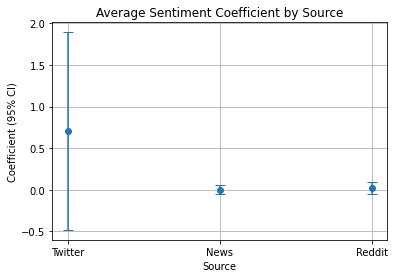

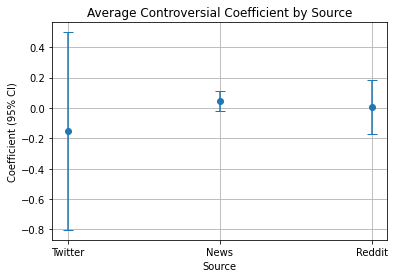

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'source': ['Twitter', 'News', 'Reddit'],
    'sentiment_coef': [0.7059, 0.0026, 0.0235],
    'sentiment_ci_lower': [-0.482, -0.049, -0.049],
    'sentiment_ci_upper': [1.894, 0.054, 0.096],
    'contro_coef': [-0.1526, 0.0435, 0.0075],
    'contro_ci_lower': [-0.803, -0.021, -0.170],
    'contro_ci_upper': [0.498, 0.108, 0.185]
}

df = pd.DataFrame(data)

print(df)

plt.figure()
plt.errorbar(df['source'], df['sentiment_coef'], 
             yerr=[df['sentiment_coef'] - df['sentiment_ci_lower'], 
                   df['sentiment_ci_upper'] - df['sentiment_coef']], 
             fmt='o', capsize=5)
plt.title('Average Sentiment Coefficient by Source')
plt.xlabel('Source')
plt.ylabel('Coefficient (95% CI)')
plt.grid(True)
plt.show()

plt.figure()
plt.errorbar(df['source'], df['contro_coef'], 
             yerr=[df['contro_coef'] - df['contro_ci_lower'], 
                   df['contro_ci_upper'] - df['contro_coef']], 
             fmt='o', capsize=5)
plt.title('Average Controversial Coefficient by Source')
plt.xlabel('Source')
plt.ylabel('Coefficient (95% CI)')
plt.grid(True)
plt.show()


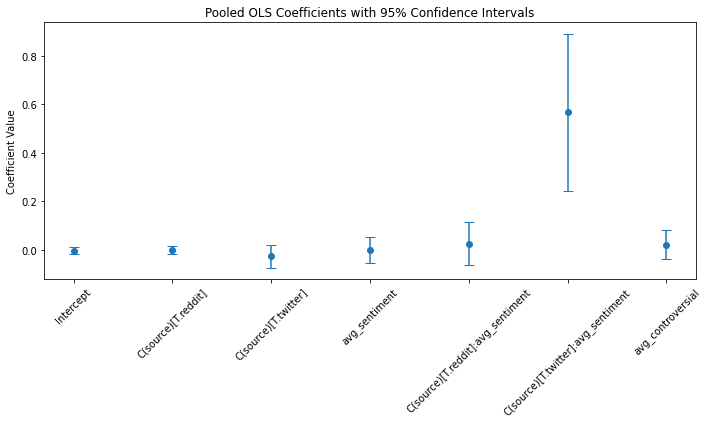

In [59]:
import matplotlib.pyplot as plt
import numpy as np


conf = pooled.conf_int()       
ci_lower = conf[0]
ci_upper = conf[1]
coeffs   = pooled.params

plt.figure(figsize=(10, 6))
plt.errorbar(
    coeffs.index, coeffs.values,
    yerr=[coeffs.values - ci_lower.values, ci_upper.values - coeffs.values],
    fmt='o', capsize=5
)
plt.xticks(rotation=45)
plt.title("Pooled OLS Coefficients with 95% Confidence Intervals")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()


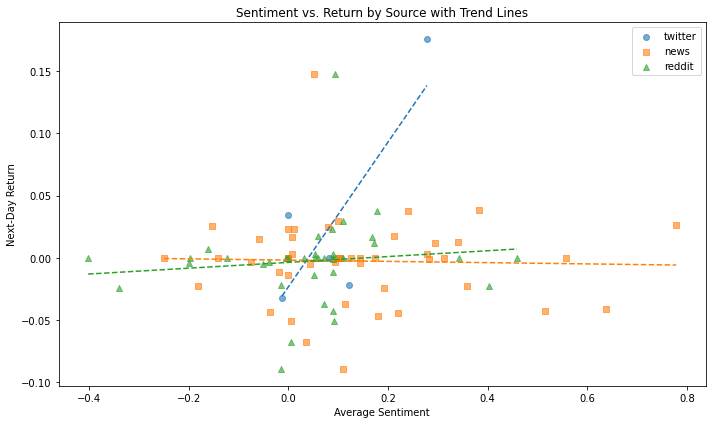

In [60]:
markers = {'twitter': 'o', 'news': 's', 'reddit': '^'}
plt.figure(figsize=(10, 6))

for src, marker in markers.items():
    sub = posts_df[posts_df['source'] == src]
    x, y = sub['avg_sentiment'], sub['next_day_return']
    plt.scatter(x, y, marker=marker, alpha=0.6, label=src)
    # Fit and plot a trend line if we have at least 2 points
    mask = x.notna() & y.notna()
    if mask.sum() > 1:
        m, b = np.polyfit(x[mask], y[mask], 1)
        x_vals = np.linspace(x.min(), x.max(), 100)
        plt.plot(x_vals, m*x_vals + b, linestyle='--')

plt.legend()
plt.xlabel("Average Sentiment")
plt.ylabel("Next-Day Return")
plt.title("Sentiment vs. Return by Source with Trend Lines")
plt.tight_layout()
plt.show()


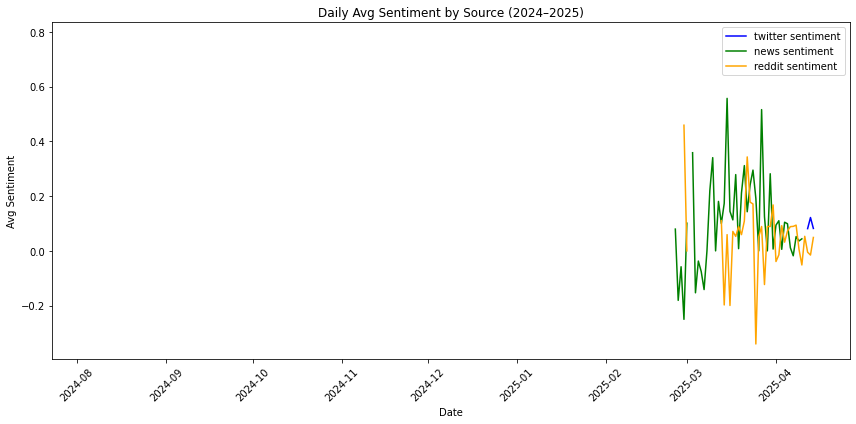

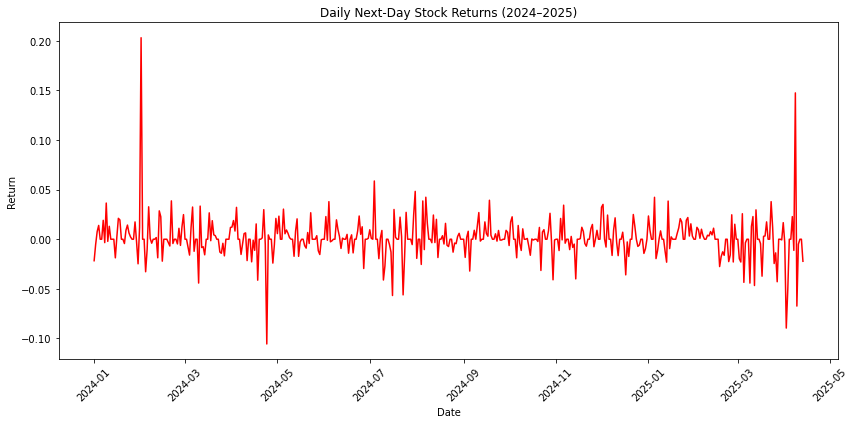

In [61]:

start, end = pd.to_datetime("2024-01-01").date(), pd.to_datetime("2025-12-31").date()

mask_posts = (posts_df['date'] >= start) & (posts_df['date'] <= end)
filtered = posts_df[mask_posts]

mask_ret = (daily_return.index.date >= start) & (daily_return.index.date <= end)
filtered_return = daily_return.loc[mask_ret]

plt.figure(figsize=(12,6))
for src,color in zip(['twitter','news','reddit'], ['blue','green','orange']):
    sub = filtered[filtered['source']==src]
    plt.plot(sub['date'], sub['avg_sentiment'], label=f"{src} sentiment", color=color)
plt.legend()
plt.title("Daily Avg Sentiment by Source (2024–2025)")
plt.xlabel("Date")
plt.ylabel("Avg Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(filtered_return.index.date, filtered_return['next_day_return'], color='red')
plt.title("Daily Next‑Day Stock Returns (2024–2025)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [62]:
from sklearn.linear_model import LogisticRegression
posts_df['return_up'] = (posts_df['next_day_return'] > 0).astype(int)


X_cls = pd.get_dummies(
    posts_df[['avg_sentiment','avg_controversial','post_count','source']],
    drop_first=True
).fillna(0)
y_true = posts_df['return_up']

clf = LogisticRegression(max_iter=1000)
clf.fit(X_cls, y_true)

y_proba = clf.predict_proba(X_cls)[:, 1]

print("Classification model ready. return_up and clf are defined.")


Classification model ready. return_up and clf are defined.


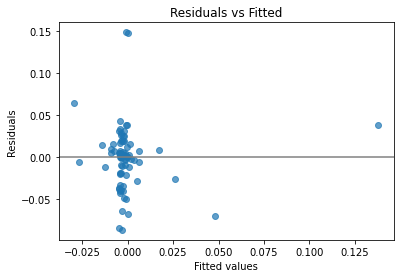

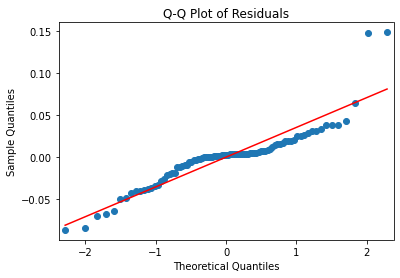

                              feature       VIF
0                           Intercept  3.261510
1                 C(source)[T.reddit]  1.329992
2                C(source)[T.twitter]  1.970352
3                       avg_sentiment  1.703380
4   C(source)[T.reddit]:avg_sentiment  1.594794
5  C(source)[T.twitter]:avg_sentiment  1.860732
6                   avg_controversial  1.394929


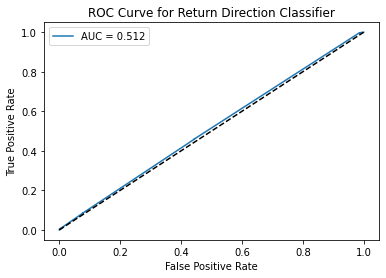

In [63]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, confusion_matrix


fitted = pooled.fittedvalues
resid  = pooled.resid

plt.scatter(fitted, resid, alpha=0.7)
plt.axhline(0, color='gray')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

sm.qqplot(resid, line='s')
plt.title("Q‑Q Plot of Residuals")
plt.show()

X = pooled.model.exog
vif_data = pd.DataFrame({
    'feature': pooled.model.exog_names,
    'VIF': [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})
print(vif_data)


fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Return Direction Classifier")
plt.legend()
plt.show()